In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score

from tqdm import tqdm

In [3]:
ds_t = xr.open_mfdataset("../era5/era5-nordics-t2m_ymon.nc")

In [4]:
ds_t

<xarray.Dataset>
Dimensions:    (latitude: 73, longitude: 111, time: 12)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-31T23:00:00 2018-02-28T23:00:00 ...
  * longitude  (longitude) float32 4.5 4.75 5.0 5.25 5.5 5.75 6.0 6.25 6.5 ...
  * latitude   (latitude) float32 71.5 71.25 71.0 70.75 70.5 70.25 70.0 ...
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<shape=(12, 73, 111), chunksize=(12, 73, 111)>
Attributes:
    CDI:          Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    Conventions:  CF-1.6
    history:      Tue Nov 20 22:18:25 2018: cdo -b 32 ymonmean -addc,-273.15 ...
    CDO:          Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/...

In [6]:
ds_t.t2m[0]

<xarray.DataArray 't2m' (latitude: 73, longitude: 111)>
dask.array<shape=(73, 111), dtype=float32, chunksize=(73, 111)>
Coordinates:
    time       datetime64[ns] 2018-01-31T23:00:00
  * longitude  (longitude) float32 4.5 4.75 5.0 5.25 5.5 5.75 6.0 6.25 6.5 ...
  * latitude   (latitude) float32 71.5 71.25 71.0 70.75 70.5 70.25 70.0 ...
Attributes:
    long_name:  2 metre temperature
    units:      K

In [7]:
df = pd.read_csv("swe_plots.csv")

In [8]:
df.dropna(inplace=True)

In [9]:
df.size

290766

In [10]:
df.head()

,year,plotid,landuseclass,easting,northing,longitude,latitude,volbirch,volcontorta,volpine,volspruce,volotherdec,pine_spruce_ratio,voltotal
0,2007,106,Skogsm,669894,7116684,18.491601,64.134697,78.134338,0.0,0.00000,275.743796,0.000000,0.000000,353.878134
1,2007,112,Skogsm,670490,7116694,18.503833,64.134493,0.000000,0.0,0.00000,3.928420,0.000000,0.000000,3.928420
4,2007,218,Skogsm,671117,7114900,18.514657,64.118114,0.000000,0.0,0.00000,216.131302,33.220735,0.000000,249.352037
5,2007,306,Skogsm,670513,7114896,18.502274,64.118376,16.051708,0.0,230.90165,20.430038,0.000000,0.918713,267.383396
6,2007,312,Skogsm,669921,7114888,18.490133,64.118596,30.301015,0.0,0.00000,5.976354,0.000000,0.000000,36.277369


In [11]:
df["voltotal"] = df["volbirch"] + \
    df["volcontorta"] + \
    df["volpine"] + \
    df["volspruce"] + \
    df["volotherdec"]

In [12]:
df["volbirchpct"] = df["volbirch"]/df["voltotal"]
df["volcontortapct"] = df["volcontorta"]/df["voltotal"]
df["volpinepct"] = df["volpine"]/df["voltotal"]
df["volsprucepct"] = df["volspruce"]/df["voltotal"]
df["volotherdec"] = df["volotherdec"]/df["voltotal"]

In [13]:
df["class"] = df.apply(lambda r: 1 if r["volpinepct"] > 0.5 else 2 if r["volsprucepct"] > 0.5 else 3, axis = 1)

In [15]:
ds_t.t2m[0].sel(longitude=18.491601, latitude=64.134697, method='nearest').values.flat[0]

-8.652276039123535

In [16]:
df["p1"] = df.apply(lambda row: ds_t.t2m[0].sel(longitude = row["longitude"], latitude = row["latitude"], method='nearest').values.flat[0], axis = 1)

In [17]:
df.head()

,year,plotid,landuseclass,easting,northing,longitude,latitude,volbirch,volcontorta,volpine,volspruce,volotherdec,pine_spruce_ratio,voltotal,volbirchpct,volcontortapct,volpinepct,volsprucepct,class,p1
0,2007,106,Skogsm,669894,7116684,18.491601,64.134697,78.134338,0.0,0.00000,275.743796,0.000000,0.000000,353.878134,0.220794,0.0,0.00000,0.779206,2,-8.652276
1,2007,112,Skogsm,670490,7116694,18.503833,64.134493,0.000000,0.0,0.00000,3.928420,0.000000,0.000000,3.928420,0.000000,0.0,0.00000,1.000000,2,-8.652276
4,2007,218,Skogsm,671117,7114900,18.514657,64.118114,0.000000,0.0,0.00000,216.131302,0.133228,0.000000,249.352037,0.000000,0.0,0.00000,0.866772,2,-8.247103
5,2007,306,Skogsm,670513,7114896,18.502274,64.118376,16.051708,0.0,230.90165,20.430038,0.000000,0.918713,267.383396,0.060033,0.0,0.86356,0.076407,1,-8.247103
6,2007,312,Skogsm,669921,7114888,18.490133,64.118596,30.301015,0.0,0.00000,5.976354,0.000000,0.000000,36.277369,0.835259,0.0,0.00000,0.164741,3,-8.247103


In [18]:
for m in tqdm(range(0, 12)):
    df["p%02d" % m] = df.apply(lambda row: ds_t.t2m[m].sel(longitude = row["longitude"], latitude = row["latitude"], method='nearest').values.flat[0], axis = 1)

100%|██████████| 12/12 [13:36<00:00, 68.02s/it]


In [19]:
df.head()

,year,plotid,landuseclass,easting,northing,longitude,latitude,volbirch,volcontorta,volpine,...,p02,p03,p04,p05,p06,p07,p08,p09,p10,p11
0,2007,106,Skogsm,669894,7116684,18.491601,64.134697,78.134338,0.0,0.00000,...,-4.075098,1.643401,7.818139,12.224805,15.329034,13.062504,8.261235,1.933939,-2.882797,-6.518259
1,2007,112,Skogsm,670490,7116694,18.503833,64.134493,0.000000,0.0,0.00000,...,-4.075098,1.643401,7.818139,12.224805,15.329034,13.062504,8.261235,1.933939,-2.882797,-6.518259
4,2007,218,Skogsm,671117,7114900,18.514657,64.118114,0.000000,0.0,0.00000,...,-3.843121,1.646205,7.837492,12.228047,15.377107,13.216541,8.493546,2.248884,-2.498997,-6.126215
5,2007,306,Skogsm,670513,7114896,18.502274,64.118376,16.051708,0.0,230.90165,...,-3.843121,1.646205,7.837492,12.228047,15.377107,13.216541,8.493546,2.248884,-2.498997,-6.126215
6,2007,312,Skogsm,669921,7114888,18.490133,64.118596,30.301015,0.0,0.00000,...,-3.843121,1.646205,7.837492,12.228047,15.377107,13.216541,8.493546,2.248884,-2.498997,-6.126215


In [20]:
df.columns

Index(['year', 'plotid', 'landuseclass', 'easting', 'northing', 'longitude',
       'latitude', 'volbirch', 'volcontorta', 'volpine', 'volspruce',
       'volotherdec', 'pine_spruce_ratio', 'voltotal', 'volbirchpct',
       'volcontortapct', 'volpinepct', 'volsprucepct', 'class', 'p1', 'p00',
       'p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p07', 'p08', 'p09', 'p10',
       'p11'],
      dtype='object')

In [21]:
df2 = df[["volpinepct", "p00", "p01", "p02", "p03", "p04", "p05", "p06", "p07", "p08", "p09", "p10", "p11"]]

In [22]:
df2

,volpinepct,p00,p01,p02,p03,p04,p05,p06,p07,p08,p09,p10,p11
0,0.000000,-8.652276,-8.165313,-4.075098,1.643401,7.818139,12.224805,15.329034,13.062504,8.261235,1.933939,-2.882797,-6.518259
1,0.000000,-8.652276,-8.165313,-4.075098,1.643401,7.818139,12.224805,15.329034,13.062504,8.261235,1.933939,-2.882797,-6.518259
4,0.000000,-8.247103,-7.846513,-3.843121,1.646205,7.837492,12.228047,15.377107,13.216541,8.493546,2.248884,-2.498997,-6.126215
5,0.863560,-8.247103,-7.846513,-3.843121,1.646205,7.837492,12.228047,15.377107,13.216541,8.493546,2.248884,-2.498997,-6.126215
6,0.000000,-8.247103,-7.846513,-3.843121,1.646205,7.837492,12.228047,15.377107,13.216541,8.493546,2.248884,-2.498997,-6.126215
7,0.076235,-8.247103,-7.846513,-3.843121,1.646205,7.837492,12.228047,15.377107,13.216541,8.493546,2.248884,-2.498997,-6.126215
8,0.000000,-8.652276,-8.165313,-4.075098,1.643401,7.818139,12.224805,15.329034,13.062504,8.261235,1.933939,-2.882797,-6.518259
12,1.000000,-8.545979,-8.091494,-4.182270,1.410822,7.538047,11.890679,15.052565,12.842144,8.105490,1.880271,-2.966542,-6.522335
15,1.000000,-8.545979,-8.091494,-4.182270,1.410822,7.538047,11.890679,15.052565,12.842144,8.105490,1.880271,-2.966542,-6.522335
16,0.908827,-8.545979,-8.091494,-4.182270,1.410822,7.538047,11.890679,15.052565,12.842144,8.105490,1.880271,-2.966542,-6.522335


In [23]:
rf = RandomForestRegressor(n_estimators=100, max_depth=20)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df2[df2.columns[1:]], df2["volpinepct"])

In [25]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [26]:
y_pred = rf.predict(X_test)

In [27]:
mean_squared_error(y_test, y_pred)

0.1392144881894942

In [28]:
r2_score(y_test, y_pred)

0.18033684796879723

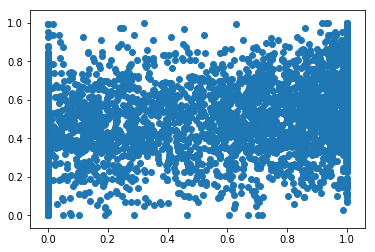

In [29]:
plt.scatter(y_test, y_pred)

In [30]:
df3 = df[["class", "p00", "p01", "p02", "p03", "p04", "p05", "p06", "p07", "p08", "p09", "p10", "p11"]]

In [31]:
df3.head()

,class,p00,p01,p02,p03,p04,p05,p06,p07,p08,p09,p10,p11
0,2,-8.652276,-8.165313,-4.075098,1.643401,7.818139,12.224805,15.329034,13.062504,8.261235,1.933939,-2.882797,-6.518259
1,2,-8.652276,-8.165313,-4.075098,1.643401,7.818139,12.224805,15.329034,13.062504,8.261235,1.933939,-2.882797,-6.518259
4,2,-8.247103,-7.846513,-3.843121,1.646205,7.837492,12.228047,15.377107,13.216541,8.493546,2.248884,-2.498997,-6.126215
5,1,-8.247103,-7.846513,-3.843121,1.646205,7.837492,12.228047,15.377107,13.216541,8.493546,2.248884,-2.498997,-6.126215
6,3,-8.247103,-7.846513,-3.843121,1.646205,7.837492,12.228047,15.377107,13.216541,8.493546,2.248884,-2.498997,-6.126215


In [32]:
clf = RandomForestClassifier(n_estimators=500, max_depth=30)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df3[df3.columns[1:]], df3["class"])

In [34]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [35]:
y_pred = clf.predict(X_test)

In [36]:
accuracy_score(y_pred, y_test)

0.5397650683612555

In [37]:
confusion_matrix(y_pred, y_test)

array([[1714,  749,  498],
       [ 627, 1032,  375],
       [  72,   69,   57]])